This project is based on dog breed classification and to also display resembling dog category if human get detected. Here we gave 133 categories of dogs with 6689 training images, 835 validation and 836 test images. For human face training we have 13233 images. We use inception pre-train network. For human face detection we are using openCV.

In [1]:
import numpy as np
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from google.colab import files
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TensorFlow 2.x selected.


In [0]:
#mount google drive 

drive.mount("/content/drive")

In [0]:
#unzip human images dataset stored in drive

!unzip -uq "/content/drive/My Drive/lfw" -d "/content"

In [0]:
#unzip dog images dataset stored in drive
!unzip -uq "/content/drive/My Drive/dogImages" -d "/content"

In [0]:
# file paths for generalization and analysis

human_files = np.array(glob("/content/lfw/*/*"))
dog_files = np.array(glob("/content/dogImages/*/*/*"))

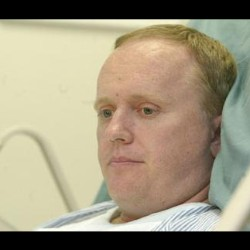

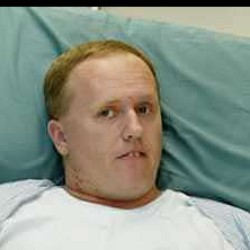

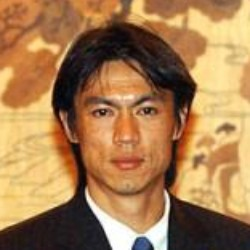

In [6]:
from IPython.display import Image
for i in human_files[:3]:
    display(Image(filename=i))

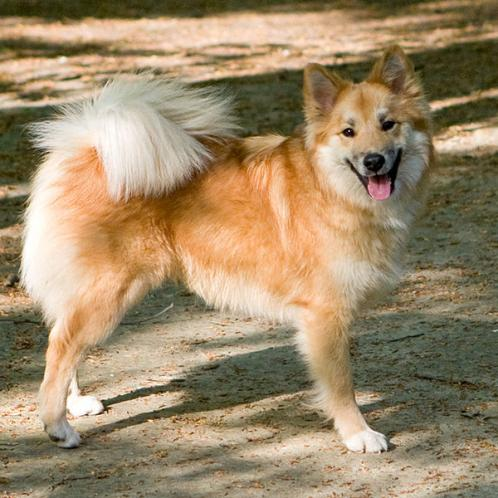

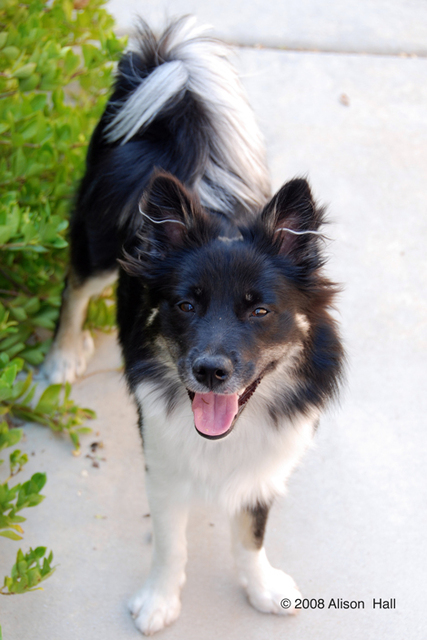

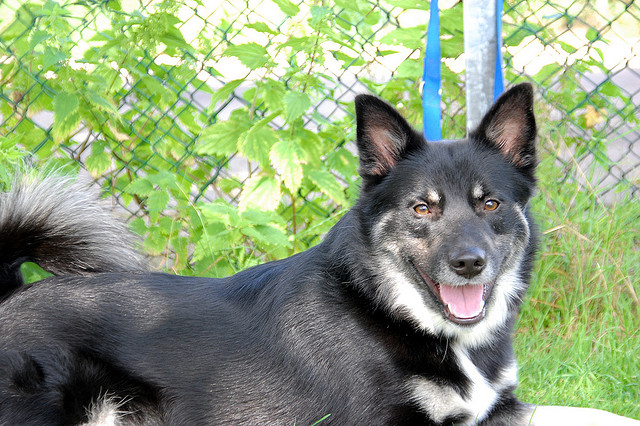

In [7]:
from IPython.display import Image
for i in dog_files[:3]:
    display(Image(filename=i))

In [0]:
#We use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images
#OpenCV provides many pre-trained face detectors, stored as XML files on github.
#Therefore we upload 'haarcascade_frontalface_alt.xml' file here.

files.upload()

Number of faces detected: 1


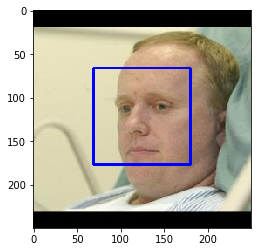

In [10]:
import cv2                                              

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()

In [0]:
#function for human face detection

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [0]:
#function to count how many faces are correctly detected

def face_detection(file):
    human_num=0
    for image in file:
        if face_detector(image):
            human_num+=1
    return human_num

In [14]:
print("out of {}, total human face correctly detected: {}" .format(len(human_files), face_detection(human_files)))

out of 13233, total human face correctly detected: 13064


In [0]:
import os

#make different directories for further use 

base_dir="./dogImages"
train_dir=os.path.join(base_dir, "train")
test_dir=os.path.join(base_dir, "test")
valid_dir=os.path.join(base_dir, "valid")

In [0]:
# Using Image Data genrator for image augmentation

train_image_gen=ImageDataGenerator(rescale=1./255, rotation_range=45, zoom_range=0.3, shear_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True,
                                   fill_mode="nearest")
valid_image_gen=ImageDataGenerator(rescale=1./255)

In [17]:
#make batches and applying image augmenatation

batch_size=32
image_shape=299

train_data_gen=train_image_gen.flow_from_directory(train_dir, batch_size=batch_size, shuffle=True,
                                                   target_size=(image_shape, image_shape), class_mode="sparse")
valid_data_gen=valid_image_gen.flow_from_directory(valid_dir, batch_size=batch_size, 
                                                   target_size=(image_shape, image_shape), class_mode="sparse")

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [0]:
import tensorflow_hub as hub

# url for pre-trained inception network in tensorflow hub
url="https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

#we are not going to retrain inception model so setting trainable to false
feature_extractor=hub.KerasLayer(url, input_shape=(image_shape, image_shape, 3), trainable=False)

In [0]:
# defining last few layers to make prediction according to our requirements
model=tf.keras.Sequential([feature_extractor,
                           tf.keras.layers.Dense(1024, activation="relu"),
                           tf.keras.layers.Dense(512, activation="relu"),
                           tf.keras.layers.Dense(133, activation="softmax")
                           ])

In [0]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 24,493,989
Trainable params: 2,691,205
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
accuracy_threshold = 0.90
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > accuracy_threshold):   
          print("\nReached {} accuracy, so stopping training.." .format(accuracy_threshold*100))   
          self.model.stop_training = True


callbacks=myCallback()

In [26]:
#training the model on 10 epochs and also validating simultaneously

epochs=10
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history=model.fit_generator(train_data_gen, epochs=epochs, steps_per_epoch=int(np.ceil(6680/batch_size)),
                            validation_data=valid_data_gen, validation_steps=int(np.ceil(835 / batch_size)),
                            callbacks=[callbacks])

Epoch 1/10
209/209 [==============================] - 198s 945ms/step - loss: 0.8681 - accuracy: 0.7349 - val_loss: 0.4821 - val_accuracy: 0.8527
Epoch 2/10
209/209 [==============================] - 194s 929ms/step - loss: 0.7489 - accuracy: 0.7723 - val_loss: 0.5348 - val_accuracy: 0.8240
Epoch 3/10
209/209 [==============================] - 194s 927ms/step - loss: 0.6787 - accuracy: 0.7880 - val_loss: 0.4465 - val_accuracy: 0.8659
Epoch 4/10
209/209 [==============================] - 195s 931ms/step - loss: 0.6415 - accuracy: 0.8021 - val_loss: 0.4601 - val_accuracy: 0.8527
Epoch 5/10
209/209 [==============================] - 191s 913ms/step - loss: 0.6126 - accuracy: 0.8105 - val_loss: 0.4187 - val_accuracy: 0.8671
Epoch 6/10
209/209 [==============================] - 193s 923ms/step - loss: 0.5506 - accuracy: 0.8266 - val_loss: 0.4171 - val_accuracy: 0.8659
Epoch 7/10
209/209 [==============================] - 197s 944ms/step - loss: 0.5218 - accuracy: 0.8326 - val_loss: 0.4617 -

Text(0.5, 1.0, 'trainin and validation loss')

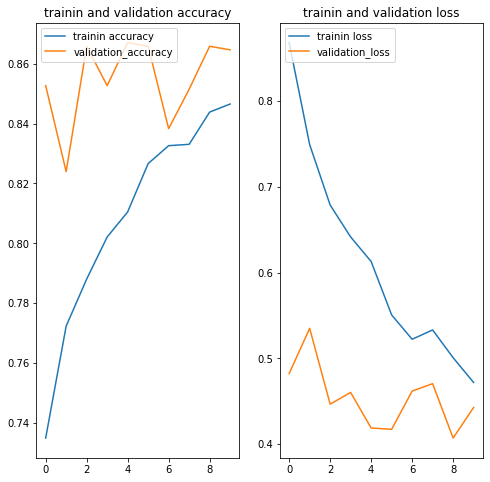

In [27]:
# visulization of accuracy and loss

accuracy=history.history["accuracy"]
val_accuracy=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

epoch_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range, accuracy, label="trainin accuracy")
plt.plot(epoch_range, val_accuracy, label="validation_accuracy")
plt.legend(loc="upper left")
plt.title("trainin and validation accuracy")

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label="trainin loss")
plt.plot(epoch_range, val_loss, label="validation_loss")
plt.legend(loc="upper left")
plt.title("trainin and validation loss")

In [28]:
# converting test data into image generator and making batches

test_gen=ImageDataGenerator(rescale=1./255)
test_data_gen=test_gen.flow_from_directory(test_dir, batch_size=32, target_size=(image_shape, image_shape), 
                                           class_mode="sparse")

Found 836 images belonging to 133 classes.


In [0]:
import time

# save model for future use in keras format
t=time.time()

export_file_path="./{}.h5".format(int(t))
model.save(export_file_path)

In [30]:
#now we reload the saved model and use it for further operations can be applied on it
reloaded_model=tf.keras.models.load_model(export_file_path, 
                                          custom_objects={"KerasLayer":hub.KerasLayer})

reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 24,493,989
Trainable params: 2,691,205
Non-trainable params: 21,802,784
_________________________________________________________________


In [31]:
print("Loss and accuracy on test data: ",model.evaluate_generator(test_data_gen, steps=int(np.ceil(836/batch_size))))
print("Loss and accuracy on test data using keras's saved model: ",reloaded_model.evaluate_generator(test_data_gen, steps=int(np.ceil(836/batch_size))))

Loss and accuracy on test data:  [0.4362788365946876, 0.8564593]
Loss and accuracy on test data using keras's saved model:  [0.4443911788640199, 0.8564593]


In [32]:
# now we are saving model in tensorflow format

t=time.time()
export_file_path_sm="./{}".format(int(t))
tf.saved_model.save(model, export_file_path_sm)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1575579636/assets


INFO:tensorflow:Assets written to: ./1575579636/assets


In [0]:
#Now reload saved model

reloaded_model_sm=tf.saved_model.load(export_file_path_sm)

Since tf's saved model don't have .fit, .evaluate and .predict methods.Therefore, we can't simply take your reloaded_tf_model and keep training it by running .fit, so to perform these operations we have to load saved model as keras model. Because keras model has all these methods. Tf's saved model can be used for depolying or sharing.

In [34]:
#Now according to above reason we load saved model as keras model
reloaded_model_sm1=tf.keras.models.load_model(export_file_path_sm,
                                              custom_objects={"KerasLayer":hub.KerasLayer})
reloaded_model_sm1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 24,493,989
Trainable params: 2,691,205
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
# performing model evaluation on test data using reloaded model
reloaded_model_sm1.evaluate_generator(test_data_gen, steps=int(np.ceil(836/batch_size)))

[0.4172380896699097, 0.8564593]

In [36]:
#extracting class labels

class_names = [item[4:].replace("_", " ") for item in os.listdir("/content/dogImages/test")]
class_names=np.array(class_names)
print(class_names)

['Icelandic sheepdog' 'Welsh springer spaniel' 'Bulldog' 'Canaan dog'
 'Australian shepherd' 'Affenpinscher' 'Plott' 'Komondor'
 'American water spaniel' 'Wirehaired pointing griffon' 'Chinese shar-pei'
 'Pembroke welsh corgi' 'Boykin spaniel' 'Otterhound' 'Lowchen'
 'Japanese chin' 'Briard' 'Miniature schnauzer' 'Norfolk terrier'
 'Gordon setter' 'Greyhound' 'Parson russell terrier'
 'Cavalier king charles spaniel' 'American foxhound'
 'Entlebucher mountain dog' 'Pharaoh hound' 'Brittany'
 'Manchester terrier' 'Bernese mountain dog' 'Kuvasz' 'Field spaniel'
 'Australian cattle dog' 'Belgian tervuren' 'Borzoi' 'Irish water spaniel'
 'Irish terrier' 'Great dane' 'Dachshund' 'Black and tan coonhound'
 'Boxer' 'Maltese' 'Lhasa apso' 'Nova scotia duck tolling retriever'
 'Xoloitzcuintli' 'Bouvier des flandres' 'German shepherd dog' 'Chow chow'
 'Australian terrier' 'German wirehaired pointer' 'Glen of imaal terrier'
 'Boston terrier' 'Kerry blue terrier' 'Poodle' 'Brussels griffon'
 'Engli

In [37]:
# predicting categories of dogs

image_batch, label_batch = next(iter(test_data_gen))

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names=class_names[predicted_ids]
print(predicted_class_names)

['Icelandic sheepdog' 'Cocker spaniel' 'Lakeland terrier' 'Otterhound'
 'Alaskan malamute' 'Italian greyhound' 'Ibizan hound'
 'Old english sheepdog' 'Black and tan coonhound'
 'German wirehaired pointer' 'German wirehaired pointer'
 'Bluetick coonhound' 'German pinscher' 'Greyhound' 'Belgian sheepdog'
 'American foxhound' 'Norwegian lundehund' 'Chesapeake bay retriever'
 'Afghan hound' 'Australian shepherd' 'Dachshund' 'Old english sheepdog'
 'Australian shepherd' 'Japanese chin' 'American staffordshire terrier'
 'Irish red and white setter' 'Labrador retriever' 'Doberman pinscher'
 'Australian cattle dog' 'Border terrier' 'Cocker spaniel'
 'Black russian terrier']


In [38]:
print("predicted values: ", predicted_ids)
print("label values:     ", label_batch.astype(int))

predicted values:  [  0 100  55  13  56  57  70  77  38  48  48  74 128  20  98  23  73 119
  76   4  37  77   4  15  72  59  67  63  31 120 100 110]
label values:      [  0 100  55  13  56  57  70  77  13  48  48  88 128  20  98  23  73 119
  76   4  37  77   4  15 130  59  67  63  31   6 100 110]


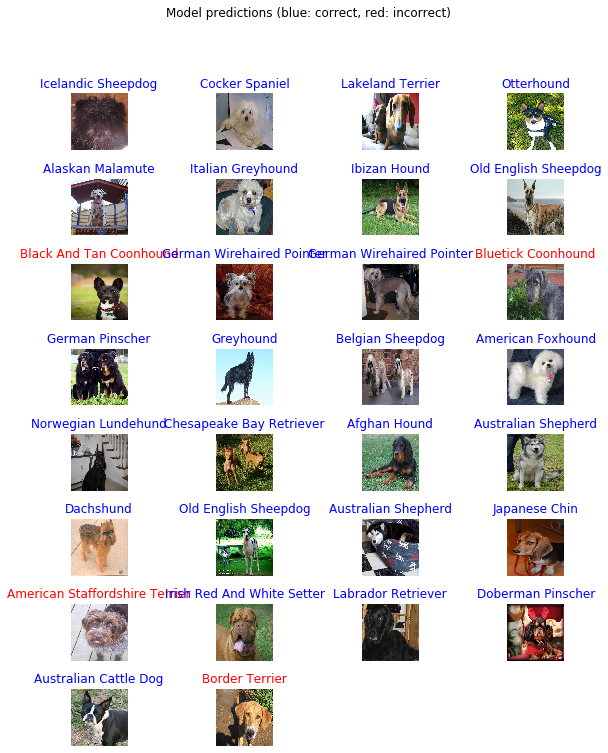

In [42]:
plt.figure(figsize=(10,12))
for n in range(30):
  plt.subplot(8,4,n+1)
  plt.subplots_adjust(hspace = 0.5)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [43]:
from keras.preprocessing import image

#predicting category of dog of any random inage feed by end user

def dog_detector(uploaded):

  for fn in uploaded.keys():
 
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(image_shape, image_shape))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images)
    prediction = tf.squeeze(classes).numpy()
    predicted_id = np.argmax(prediction)
    predicted_class_name=class_names[predicted_id]
    return predicted_class_name

Using TensorFlow backend.


In [0]:
# function to find dog breed and if human face get detected then display to which category that human belongs
def run_app(img_path):
    
    for fn in uploaded.keys():
      path = '/content/' + fn
      img = image.load_img(path, target_size=(image_shape, image_shape))
      plt.imshow(img)
      plt.axis("off")
      plt.show()

    # handle cases for a human face, dog, and neither  
    if face_detector(path):
        prediction = dog_detector(img_path)
        print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))
    elif dog_detector(img_path) in class_names:
        prediction = dog_detector(img_path)
        print("Dogs Detected!\nIt looks like a {0}".format(prediction))
    else:
        print("Error! Can't detect anything..")

### for random image testing

In [0]:
uploaded=files.upload()

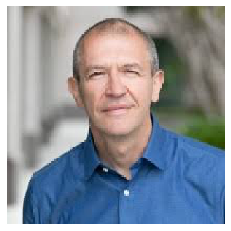

Hello, human!
If you were a dog..You may look like a Australian terrier


In [47]:
run_app(uploaded)

In [0]:
uploaded=files.upload()

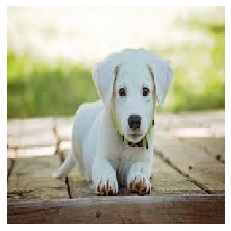

Hello, human!
If you were a dog..You may look like a Havanese


In [56]:
run_app(uploaded)